priority_goal_identifier[ 0 ]: (14.0, 11.0)
priority_goal_identifier[ 1 ]: (16.0, 12.0)
priority_goal_identifier[ 2 ]: (12.0, 12.0)
priority_goal_identifier[ 3 ]: (20.0, 6.0)
priority_goal_identifier[ 4 ]: (10.0, 9.0)
priority_goal_identifier[ 5 ]: (10.0, 5.0)
priority_goal_identifier[ 6 ]: (15.0, 14.0)
priority_goal_identifier[ 7 ]: (10.0, 14.0)
priority_goal_identifier[ 8 ]: (22.0, 4.0)
priority_goal_identifier[ 9 ]: (8.0, 5.0)
priority_goal_identifier[ 10 ]: (23.0, 2.0)
priority_goal_identifier[ 11 ]: (7.0, 12.0)
priority_goal_identifier[ 12 ]: (7.0, 2.0)
priority_goal_identifier[ 13 ]: (5.0, 3.0)
priority_goal_identifier[ 14 ]: (27.0, 2.0)
priority_goal_identifier[ 15 ]: (29.0, 7.0)
priority_goal_identifier[ 16 ]: (29.0, 10.0)
priority_goal_identifier[ 17 ]: (29.0, 2.0)
priority_goal_identifier[ 18 ]: (29.0, 11.0)
priority_goal_identifier[ 19 ]: (1.0, 6.0)
Done!


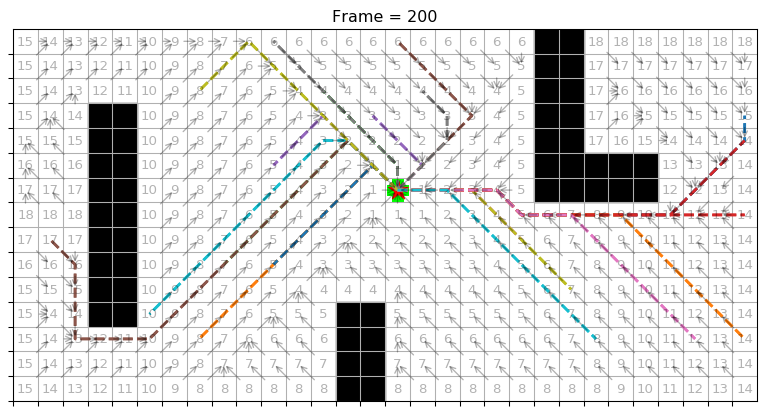

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from envSetup import EnvSetup
from customizedShape import CustomizedShape
from pathfinder import Pathfinder



# Fixing random state for reproducibility
np.random.seed(EnvSetup().seed)

# Create new Figure and an Axes which fills it.
fig = plt.figure(num="besiege", figsize=(10, 10), dpi=96, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
title_text = plt.title('')
title_template = 'Frame = %d'

# Deploy background information.
line_paths = []
dot_came_from_cost = []
path = []
path_x = []
path_y = []
# identifier_i_robot_j = {identifier_i: robot_j}
identifier_i_robot_j = {}


# Map setup parameters -- Customized paramaters.
map_width = EnvSetup().map_width
map_height = EnvSetup().map_height
n_robot = EnvSetup().n_robot
n_target = EnvSetup().n_target


# Map robots setup.
# Deploy robots.
data_robot = np.zeros(n_robot, dtype=[('position', float, 2),
                                      ('identifier', float, 2),
                                      ('color',    float, 4)])
# Deploy targets.
data_target = np.zeros(n_target, dtype=[('position', float, 2),
                                        ('color',    float, 4)])
# Deploy walls.
for shape in CustomizedShape().walls['shape']:
    ax.add_patch(shape)

# Deploy 
pathfinderObject = Pathfinder()
pathfinderObject.breadth_first_search()
came_from = pathfinderObject.came_from.copy()
cost_so_far = pathfinderObject.cost_so_far.copy()
priority_goal_identifier = pathfinderObject.priority_goal_identifier.copy()

# Draw the came_from relationship and cost_so_far of the search algorithm.
dot_came_from_cost.clear()
while len(came_from) != 0:
    item_came_from = came_from.popitem()
    current = item_came_from[0]
    parent = item_came_from[1]
    item_cost_so_far = cost_so_far.get(current)
    if parent != None:
        dot_came_from_cost.append(plt.annotate(str(item_cost_so_far),
                                               ha='center', va='center', alpha=0.3,
                                               xytext=current,
                                               xy=parent,
                                               arrowprops={'arrowstyle': '->', 'alpha': 0.3}))



# Construct the scatter which we will update during animation
# as time progess.
scatter_robot = ax.scatter(data_robot['position'][:, 0], data_robot['position'][:, 1],
                           s=256, lw=0.5, 
                           edgecolors=data_robot['color'], facecolors=data_robot['color'], 
                           marker=CustomizedShape().marker_robot)
scatter_target = ax.scatter(data_target['position'][:, 0], data_target['position'][:, 1],
                            s=256, lw=0.5, 
                            edgecolors=data_target['color'], facecolors=data_target['color'], 
                            marker=CustomizedShape().marker_target)

    
    
    
#
def init():
    
    # Map Backgroud setup.
    ax.set_xlim(0-0.5, map_width-0.5)
    ax.set_ylim(0-0.5, map_height-0.5)
    ax.set_aspect('equal')    
    x_ticks = np.arange(0-0.5, map_width-0.5, 1)
    y_ticks = np.arange(0-0.5, map_height-0.5, 1)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    title_text.set_text('')
    
    # Initialize data.
    # robot.
#     data_robot['position'] = np.around(np.random.uniform([0, 0], [map_width, map_height], (n_robot, 2)))
    data_robot['position'] = np.array(list(EnvSetup().nodes_robot_initializer.values()))
    data_robot['identifier'] = np.array(list(EnvSetup().nodes_robot_initializer.keys()))
    data_robot['color'] = np.repeat([[0., 1., 0., 1.]], n_robot, axis=0)
    # Build the table illustrating the correspondance between the identifier_i and the robot_j.
    for robot_j in np.arange(n_robot):
        identifier_i = tuple(data_robot['identifier'][robot_j])
        identifier_i_robot_j[identifier_i] = robot_j
    # target.
#     data_target['position'][0] = np.around(np.asarray([[map_width*0.5, map_height*0.5]]))
    data_target['position'] = np.array(list(EnvSetup().nodes_target_initializer.values()))
    data_target['color'] = np.repeat([[1., 0., 0., 1.]], n_target, axis=0)
    
    #
    # path = [[path_robot_1], [path_robot_2], ..., [path_robot_n]]
    path.clear()
    path_x.clear()
    path_y.clear()
    for robot_i  in np.arange(n_robot):
        path.append(pathfinderObject.reconstruct_path(tuple(data_robot['position'][robot_i])))
        path_x.append([path[robot_i][ix][0] for ix in range(len(path[robot_i]))])
        path_y.append([path[robot_i][ix][1] for ix in range(len(path[robot_i]))])

    # Draw the path of each robot.
    line_paths.clear()
    for ix in np.arange(len(path_x)):
        line_paths.append(plt.plot(path_x[ix], path_y[ix], '--', lw=2))
    
    return scatter_robot, scatter_target
    
    
# Generate the data randomly.
def data_generator_random(frame_number=0):
    
    threshold = 1e2
    step_x = 0.
    step_y = 0.
    
    while frame_number < threshold:
        # Get an index which we can use to re-spawn the oldest data.
        current_index_robot = frame_number % n_robot 

        # Pick a new position for oldest data.
        # robot.
        data_robot['position'][current_index_robot] = np.around(np.random.uniform([0+step_x, 0+step_y], [map_width-step_x, map_height-step_y], 2))
        # target.
        data_target['position'][0] = np.around(np.asarray([[map_width*0.5, map_height*0.5]]))
        # wall.
        

        # Update.
        frame_number += 1
        step_x += (map_width / 2 - 2) / (threshold)
        step_y += (map_height/ 2 - 2) / (threshold)
        
        yield data_robot, data_target    



#
def data_generator(frame_number=0):
    #
#     while path != []:
#         frame_number = frame_number + 1
#         #
#         for robot_i  in np.arange(n_robot):
#             try:
#                 data_robot['position'][robot_i] = path[robot_i].pop()
#             except IndexError:
#                 pass
#         yield data_robot, frame_number
        
    while path.count([]) != n_robot:
        frame_number = frame_number + 1
        next_positions = {}
        # Loop all the priorities.
        for priority in priority_goal_identifier.keys():
            identifier_i = priority_goal_identifier.get(priority)
            robot_j = identifier_i_robot_j.get(identifier_i)
            # 
            try:
                next_pos = path[robot_j].pop()
            except IndexError:
                next_pos = []
            # Check collision except the robot has already been at the target position.
            if next_pos == []:
                data_robot['position'][robot_j] = data_robot['position'][robot_j]
            # The position is not registed by some other robot which has a lower priority.
            elif next_pos not in next_positions.keys(): 
                next_positions[next_pos] = None
                data_robot['position'][robot_j] = next_pos
            # Otherwise, the position has already been registed by some other robot which has a lower priority.
            else:
                # Restore.
                path[robot_j].append(next_pos)
                # perserve the current position unchanged.
                current_pos = tuple(data_robot['position'][robot_j])
                next_positions[current_pos] = None
                data_robot['position'][robot_j] = current_pos
        #
        if path.count([]) == n_robot:
            exit_flag_local = True
        else:
            exit_flag_local = False
        yield exit_flag_local, data_robot, frame_number 
    
                
    

#
def update(data):
    
    exit_flag_local, foo, frame_number = data
    print('Current frame:', frame_number)
    
    if not exit_flag_local:    
        # Update the scatter collection, with the new colors and positions.
        # Update robots.
        scatter_robot.set_edgecolors(data_robot['color'])
        scatter_robot.set_facecolors(data_robot['color'])
        scatter_robot.set_offsets(data_robot['position'])
        # Update targets.
        scatter_target.set_edgecolors(data_target['color'])
        scatter_target.set_facecolors(data_target['color'])
        scatter_target.set_offsets(data_target['position'])
        # Update the title.
        title_text.set_text(title_template % frame_number)
        
        # Save.
        file_name = "./data/besiege" + str(frame_number) + ".png"
        print('Saving the file', file_name)
        plt.savefig(file_name)

        return scatter_robot, scatter_target, title_text,
    else:
        # Save.
        file_name = "./data/besiege" + str(frame_number) + ".png"
        print('Saving the file', file_name)
        plt.savefig(file_name)
        # Exit.
        print("---The simulation is done!")
        exit()
    


# Construct the animation, using the update function as the animation director.
ani = animation.FuncAnimation(fig, update, data_generator, interval=1, init_func=init,
                                   save_count=200, repeat=False, blit=True)

# print("Saving the simulation to the file 'besiege.mp4'")
# ani.save('besiege.mp4') 
# print("Saving done!")

plt.show()
